# Exercice HR Bordeaux

Importations bibliothèques

In [1]:
import openturns as ot
import numpy as np
import openturns.viewer as otv
import pylab as pl
import openturns.viewer as viewer
from matplotlib import pylab as plt

## 1. Description des données

In [2]:
# Importation des données
sample_HR = ot.Sample_ImportFromTextFile('Humidite-relative-Bordeaux-2018.csv', ';')

In [3]:
# Taille de l'échantillon
sample_HR.getSize()

2779

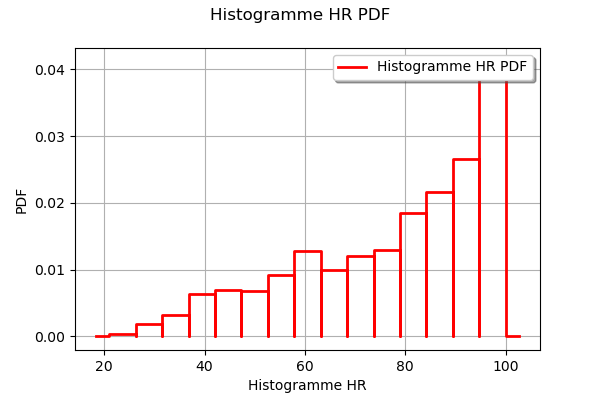

In [4]:
# Histogramme de la distribution
histo_HR = ot.HistogramFactory().build(sample_HR)
histo_HR.setDescription(["Histogramme HR"])
histo_HR.drawPDF()

In [5]:
# Autres données
m = sample_HR.computeMean()[0]
v = sample_HR.computeVariance()[0]
q25 = sample_HR.computeQuantile(0.25)[0]
q75 = sample_HR.computeQuantile(0.75)[0]
med = sample_HR.computeMedian()[0]

print("Moyenne HR de l'échantillon : ", m)
print("Variance HR de l'échantillon : ", v)
print("Quantile à 25% de l'échantillon : ", q25)
print("Quantile à 75% de l'échantillon : ", q75)
print("Médiane de l'échantillon : ", med)

Moyenne HR de l'échantillon :  77.22058294350485
Variance HR de l'échantillon :  351.3001377450075
Quantile à 25% de l'échantillon :  64.0
Quantile à 75% de l'échantillon :  94.0
Médiane de l'échantillon :  83.0


Observations :

- Pas de valeurs inférieures à 20% d'HR.
- Valeurs comprises entre 20% et 100% d'HR.
- Forte croissance de la densité de probabilité dans le dernier quart de l'échantillon trié.
- Allure exponentielle de la densité de probabilité discrète.

## 2. Ajustement de la loi Beta

In [6]:
HRBeta = ot.BetaFactory().build(sample_HR)
HRBeta

class=Beta name=Beta dimension=1 alpha=1.88684 beta=0.765074 a=20.9716 b=100.028

In [7]:
# Calcul de l'espérance et de la variance de la loi HRBeta à partir des paramètres estimés.

[alpha, beta, a, b] = HRBeta.getParameter()

m_chap = a + (b-a)*(alpha/(alpha+beta))
v_chap = (b-a)**2 * (alpha*beta/((alpha+beta)**2 * (alpha+beta+1)))

print("Moyenne de la loi HRBeta : ", m_chap)
print("Variance de la loi HRBeta : ", v_chap)


Moyenne de la loi HRBeta :  77.22058294350487
Variance de la loi HRBeta :  351.3001377450076


Observations :

- La loi HRBeta est définie sur l'intervalle $[20.97; 100.08]$ et c'est déjà ce qui avait pû être observé sur l'histogramme.
- $\alpha$ et $\beta$ sont positifs strictements.
- Les calculs de la moyenne et de la variance de la loi HRBeta sont sensiblement identiques à la moyenne et la variance de l'échantillon sample_HR à partir du quel on a estimé les paramètres de HRBeta.

In [71]:
# Fonction d'affichage pour la superposition de PDF 

def affichagePDF_HR(histo, loi, loi_ks = None, loi_ML = None, loi_ML2 = None):
    """
        Fonction permettant de superposer un histogramme et des densités continues.
    _______
    Parameters :
        - histo : Un histogramme.
        - loi : Une loi ajustée à partir d'un échantillon.
        - loi_ks : Une estimation de loi par lissage à noyau.  

    Returns :

    """
    histo.setDescription(['Histogramme'])
    graph = histo.drawPDF()
    loi.setDescription(['Loi ajustée HRBeta'])
    graph.add(loi.drawPDF())
    graph.setXTitle("x")
    graph.setYTitle("PDF")
    graph.setTitle(
    "Ajustement de la loi à partir d'un échantillon donné")
    if(loi_ks!= None):
        loi_ks.setDescription(['Loi KernelSmoothing'])
        graph.add(loi_ks.drawPDF())
    if(loi_ML!= None):
        loi_ML.setDescription(['Loi ajustée ML'])
        graph.add(loi_ML.drawPDF())
    if(loi_ML2!= None):
        loi_ML2.setDescription(['Loi ajustée ML2'])
        graph.add(loi_ML2.drawPDF())
    graph.setColors(["blue", "red", "green", "yellow", "brown"])
    graph.setLegendPosition('topleft')
    view = viewer.View(graph)

    return view

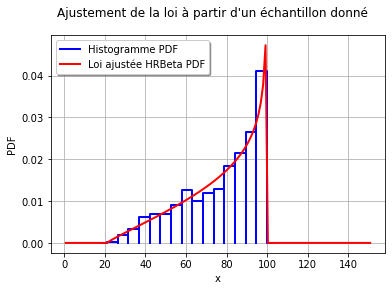

In [9]:
affichagePDF_HR(histo_HR, HRBeta)

Observations :

L'ajustement suit la tendance et semble satisfaisant.

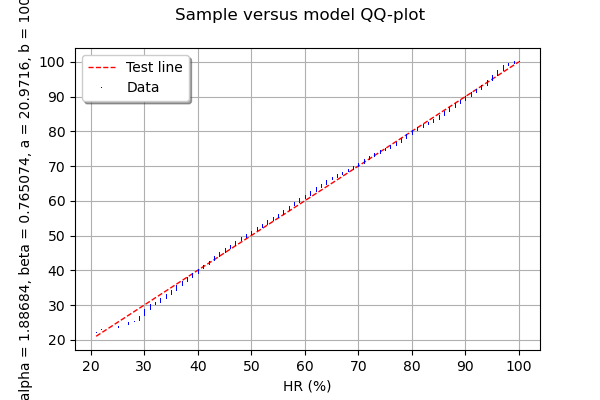

In [10]:
ot.VisualTest_DrawQQplot(sample_HR, HRBeta)


Observations :

L'ajustement semble visuellement satisfaisant, même si la queue inférieure de la disribution de l'échantillon est légèrement inférieure à celle de la distribution estimée.

In [11]:
# Test de Lilliefors
beta = ot.BetaFactory()
dist, testLilliefors_result = ot.FittingTest_Lilliefors(sample_HR, beta)
testLilliefors_result

class=TestResult name=Unnamed type=Lilliefors Beta binaryQualityMeasure=false p-value threshold=0.05 p-value=0 statistic=0.0637314 description=[Beta(alpha = 1.88684, beta = 0.765074, a = 20.9716, b = 100.028) vs sample Humidite-relative-Bordeaux-2018.csv]

In [12]:
dist == HRBeta

True

In [13]:
testLilliefors_result.getPValue()

0.0

In [14]:
testLilliefors_result.getBinaryQualityMeasure()

False

Conclusion sur le test :

Après avoir estimé les paramètres de la loi Beta à partir de l'échantillon, le test de Lilliefors nous indique que la loi Beta ne peut être la distribution associée à l'échantillon, malgré les bons résultats visuels obtenus à partir de la superposition des PDF et du QQPlot.

## 3. Distribution de l'estimation des paramètres

In [15]:
fittedRes = ot.BetaFactory().buildEstimator(sample_HR)
fittedRes

class=DistributionFactoryResult distribution=class=Beta name=Beta dimension=1 alpha=1.88684 beta=0.765074 a=20.9716 b=100.028 parameterDistribution=class=KernelMixture name=KernelMixture kernel=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] bandwidth=class=Point name=Unnamed dimension=4 values=[0.0431894,0.0145505,0.417014,0.000149897] sample=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=100 dimension=4 data=[[1.88058,0.766058,20.9716,100.028],[1.88675,0.78847,20.9716,100.028],[1.74596,0.731651,21.972,100.028],[1.77696,0.744755,21.972,100.028],[1.76846,0.744844,21.972,100.028],[1.85666,0.764254,20.9716,100.028],[1.82406,0.756626,20.9716,100.028],[1.88861,0.773968,20.9716,100.028],[1.9543,0.787413,20.9716,100.028],[1.85984,0.753091,20.9716,100.028],[1.76713,0.752688,21.972,100.028],[1.98946,0.793368,20.9716,100.028],[1.67497,0.760963,24.973,100.027],[1.89066,0.779573,20.9716,100.028],[1.90591,0.761937,20.9716,100.028],[2.0151,0.766736,20.9716,100.028],[1.87753,0.762331,20.9716,100.028],[1.80159,0.767622,20.9716,100.028],[1.8782,0.765225,20.9716,100.028],[1.84511,0.768789,20.9716,100.028],[1.92225,0.776807,20.9716,100.028],[1.85961,0.773558,21.972,100.028],[1.89865,0.748525,20.9716,100.028],[1.87654,0.781799,20.9716,100.028],[1.70628,0.735685,24.973,100.027],[1.91253,0.781111,20.9716,100.028],[1.88249,0.742481,21.972,100.028],[1.65242,0.714542,24.973,100.027],[1.83384,0.751061,20.9716,100.028],[1.8645,0.776084,20.9716,100.028],[1.76337,0.724315,21.972,100.028],[1.8275,0.747818,20.9716,100.028],[1.73663,0.714265,20.9716,100.028],[1.6775,0.714315,24.973,100.027],[1.83391,0.752015,20.9716,100.028],[1.77793,0.743532,21.972,100.028],[1.8625,0.74816,20.9716,100.028],[1.95471,0.777075,20.9716,100.028],[1.86214,0.781274,20.9716,100.028],[1.79121,0.738387,20.9716,100.028],[1.76446,0.745562,21.972,100.028],[1.95451,0.799121,20.9716,100.028],[1.82833,0.747164,21.972,100.028],[1.88175,0.739054,20.9716,100.028],[1.77501,0.736088,21.972,100.028],[1.83148,0.770398,21.972,100.028],[1.83539,0.764688,20.9716,100.028],[1.8297,0.734965,20.9716,100.028],[1.86872,0.739092,20.9716,100.028],[1.91048,0.755117,20.9716,100.028],[1.80177,0.731573,21.972,100.028],[1.90117,0.755486,21.972,100.028],[1.71468,0.724829,24.973,100.027],[1.86518,0.753979,20.9716,100.028],[1.95973,0.77122,20.9716,100.028],[1.91172,0.789679,20.9716,100.028],[1.67265,0.71756,24.973,100.027],[1.62998,0.738598,26.9738,100.026],[1.7976,0.765221,20.9716,100.028],[1.88029,0.775882,21.972,100.028],[1.91482,0.782374,20.9716,100.028],[1.87387,0.75383,20.9716,100.028],[1.81991,0.746801,20.9716,100.028],[1.79802,0.743591,21.972,100.028],[1.96639,0.797508,20.9716,100.028],[1.92823,0.784167,20.9716,100.028],[1.88001,0.724994,20.9716,100.028],[1.89546,0.764655,20.9716,100.028],[1.8965,0.76894,20.9716,100.028],[1.9318,0.73576,20.9716,100.028],[1.78203,0.751673,21.972,100.028],[1.93667,0.774613,20.9716,100.028],[1.81698,0.733695,21.972,100.028],[1.91704,0.775665,20.9716,100.028],[1.92441,0.757064,20.9716,100.028],[1.80217,0.743666,21.972,100.028],[1.67833,0.748478,24.973,100.027],[1.85385,0.774618,20.9716,100.028],[1.80797,0.72336,21.972,100.028],[1.95064,0.812156,20.9716,100.028],[1.77903,0.72889,21.972,100.028],[1.87936,0.794007,20.9716,100.028],[1.84766,0.775008,20.9716,100.028],[1.85216,0.772862,20.9716,100.028],[1.7877,0.712778,21.972,100.028],[1.68914,0.716673,24.973,100.027],[1.86904,0.774631,21.972,100.028],[1.83857,0.747722,20.9716,100.028],[1.84604,0.774634,20.9716,100.028],[1.78359,0.73968,21.972,100.028],[1.92062,0.750982,20.9716,100.028],[1.84067,0.752796,21.972,100.028],[1.9082,0.759078,20.9716,100.028],[1.62667,0.727906,24.973,100.027],[1.71576,0.710195,24.973,100.027],[1.87231,0.776279,20.9716,100.028],[1.88344,0.

Par défaut, il semble que ce soit encore la méthode des moments qui est utilisée pour estimer les paramètres.

In [16]:
dist_param = fittedRes.getParameterDistribution()

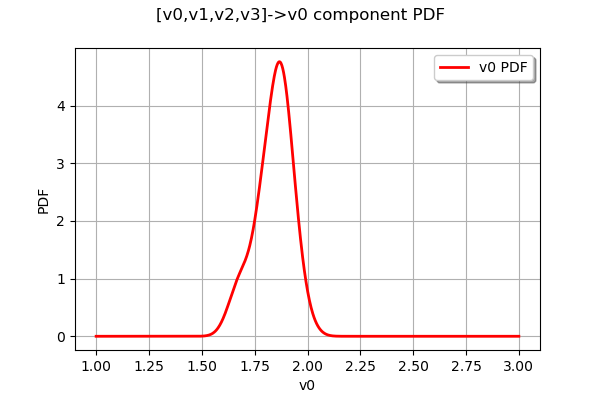

In [17]:
# PDF du premier paramètre de forme, alpha
dist_param.drawMarginal1DPDF(0, 1.0, 3.0, 1000)

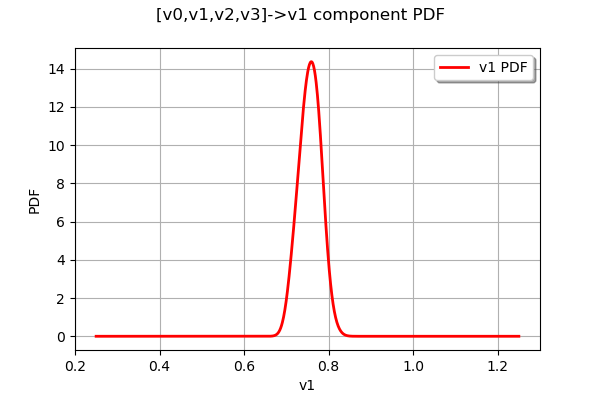

In [18]:
# PDF du second paramètre de forme, beta
dist_param.drawMarginal1DPDF(1, 0.25, 1.25, 1000)

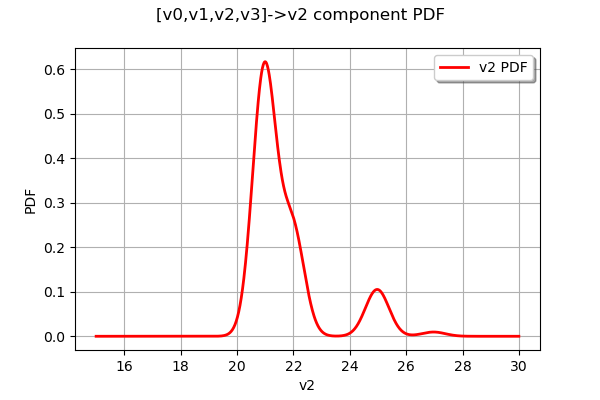

In [19]:
# PDF du minimum
dist_param.drawMarginal1DPDF(2, 15.0, 30.0, 1000)

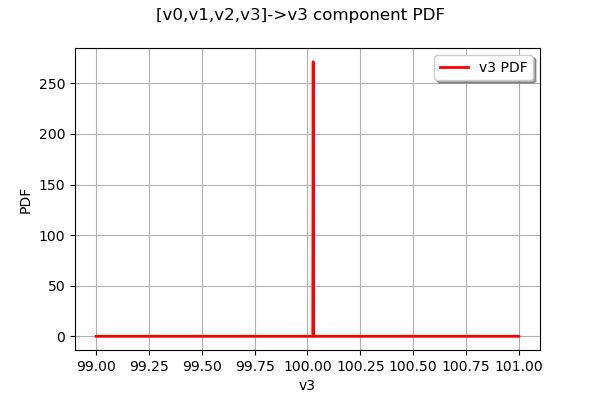

In [20]:
# PDF du maximum
dist_param.drawMarginal1DPDF(3, 99.0, 101.0, 1000)

Intervalles de confiance (à vérif)

In [21]:
confInt = dist_param.computeBilateralConfidenceInterval(0.95)
confInt

class=Interval name=Unnamed dimension=4 lower bound=class=Point name=Unnamed dimension=4 values=[1.59624,0.69322,20.0239,100.026] upper bound=class=Point name=Unnamed dimension=4 values=[2.0357,0.818241,26.7231,100.029] finite lower bound=[1,1,1,1] finite upper bound=[1,1,1,1]

Longueur des intervalles de confiance

In [22]:
longueur_int = confInt.getUpperBound() - confInt.getLowerBound()

In [23]:
longueur_int[0]

0.4394646966407785

In [24]:
longueur_int[1]

0.12502081563115963

In [25]:
longueur_int[2]

6.699161646883947

In [26]:
longueur_int[3]

0.00240803797524336

Observations :

Le paramètre le mieux estimé est le maximum b (dernier paramètre pour la loi Beta). En effet, la longueur de son intervalle de confiance est de l'ordre de $10^{-2}$. Par contre, toujours en observant la longueur des intervalles de confiance, on peut dire que le minimum est le parmètre le moins bien estimé. De plus, sa marginale semble faire apparaître 2 modes.

## 4. Recherche de la meilleure loi ajustée au sens du critère BIC

In [27]:
# Création d'une collection de distributions
distcoll = ot.DistributionFactory_GetContinuousUniVariateFactories()

In [28]:
# Taille de la collection
distcoll.getSize()

31

In [29]:
# Test modèle BIC
best_model, best_BIC = ot.FittingTest_BestModelBIC(sample_HR, distcoll)

WRN - Warning! Impossible to use factory BurrFactory. Reason=InvalidArgumentException : Error: cannot estimate the k parameter
WRN - Warning! Impossible to use factory DirichletFactory. Reason=InvalidArgumentException : Error: the sample contains points not in the unit simplex: x=class=Point name=Unnamed dimension=1 values=[82]
WRN - Warning! Impossible to use factory FisherSnedecorFactory. Reason=InvalidArgumentException : Error d1 of a FisherSnedecor distribution must be positive
WRN - Warning! Impossible to use factory MeixnerDistributionFactory. Reason=InvalidArgumentException : Error: cannot estimate a MeixnerDistribution distribution if the sample kurtosis=2.50025 is not greater than 2*skewness^2+3=4.14977
WRN - Warning! Impossible to use factory TriangularFactory. Reason=InvalidArgumentException : M MUST be enclosed between a and b
WRN - TNC went to an abnormal point=[nan,nan,nan]
WRN - Switch to finite difference to compute the gradient at point=[-713796,980845,713992]
WRN - Sw

In [30]:
# Meilleur modèle (selon critère BIC)
best_model

class=Beta name=Beta dimension=1 alpha=1.88684 beta=0.765074 a=20.9716 b=100.028

In [31]:
best_model == HRBeta

True

Observations : 

Selon le critère BIC, c'est encore la loi Beta qui approche le mieux la distribution de notre échantillon. On remarque que c'est exactement la même distribution que celle obtenue par méthode des moments et non-validée par le test de Lilliefors.

## 5. Méthode d'estimation à noyau

In [33]:
ks_distHR = ot.KernelSmoothing().build(sample_HR)
ks_distHR.setDescription(["HR par KS"])

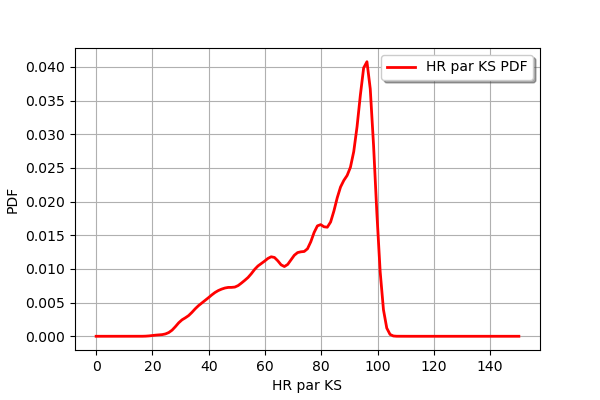

In [34]:
ks_distHR.drawPDF()

Observations : 

- La croissance de la distribution n'est pas aussi lisse qu'avec les estimations précédentes, et pour cause l'estimation n'est ici plus paramétrique.
- La distribution semble prendre pour support l'intervalle $[27;105]$ (en %). Là encore le support semble légèrement décalé vers de plus grandes valeurs par rapport aux estimations précédentes.

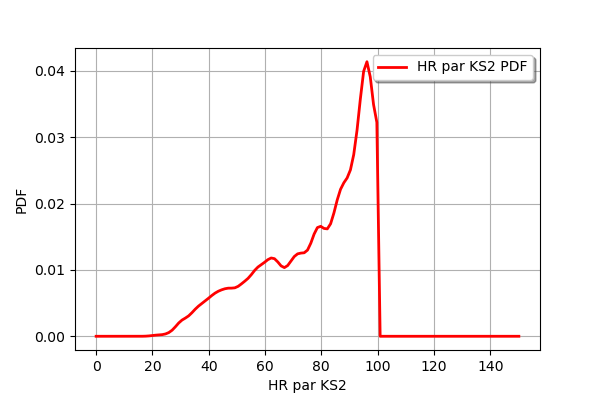

In [35]:
ks = ot.KernelSmoothing()
ks.setBoundingOption(2)
ks_distHR2 = ks.build(sample_HR)
ks_distHR2.setDescription(['HR par KS2'])
ks_distHR2.drawPDF()

Observations :

Les observations sont sensiblement identiques à celles de la figure précédente à la différence qu'une troncature a été effectuée sur le bord droit de manière à observer une densité de probabilité sur des valeurs comprises entre $27\%$ et $100\%$.

Test de Kolmogorov :

Comme on fait l'hypothèse que l'on connaît la loi, via l'estimation non-paramétrique de la distribution de l'échantillon, on est bien dans le cadre du test de Kolmogorov.

In [36]:
# Réalisation du test de Kolmogorov-Smirnov
testKolmogorov_result = ot.FittingTest.Kolmogorov(sample_HR, ks_distHR2)

In [37]:
# P-Valeur
testKolmogorov_result.getPValue()

0.0077953227664465195

In [38]:
# Résultat
testKolmogorov_result.getBinaryQualityMeasure()

False

Le résultat du test n'est pas concluant, ce qui est dérangeant puisqu'aucun paramêtre n'a été estimé et que la distribution prise pour réaliser le test a été construire à partir d'une méthode de lissage à noyau. Donc cette distribution est indépendante de la taille de l'échantillon sample_HR.

## 6. Synthèse

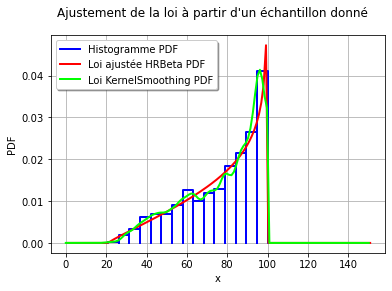

In [39]:
affichagePDF_HR(histo_HR, HRBeta, ks_distHR2)

Observations : 

Les deux lois à densité semblent correspondre à l'échantillon, sans pour autant être validées par le test basé sur la statistique de Kolmogorov-Smirnov. Dans l'immédiat, on peut dire que l'approche paramétrique par méthode des moments et l'approche non-paramétrique par lissage à noyau, ne fonctionnent pas pour notre jeu de données. Néanmoins l'hypothèse d'une loi Beta semble cohérente avec l'allure de notre échantillon.

## 7. Estimation d'une loi Beta par la méthode du maximum de vraisemblance

In [40]:
# Estimation des paramètres

def Beta_MaxLikelihood(Sample, epsilon):
    """
        Estimation des paramètres d'une loi Beta, à partir d'un échantillon, par maximum de vraisemblance.

    Parameters : 
        - Sample : L'échantillon dont on dispose.

    Returns : 
        - Beta : Distribution Beta estimée par maximum de vraisemblance.
    """
    
    # Minimum et maximum
    a = Sample.getMin()[0]* (1-epsilon)
    b = Sample.getMax()[0]* (1+epsilon)

    # Alpha et beta
    factory = ot.MaximumLikelihoodFactory(ot.Beta())
    factory.setKnownParameter([a, b], [2, 3])
    bounds_lower = [ot.SpecFunc.MinScalar] * 2
    bounds_upper = [1.0] * 2  # Disable anyway (ignored)
    interval = ot.Interval(bounds_lower, bounds_upper, [True] * 2, [False] * 2)
    factory.setOptimizationBounds(interval) 

    Beta = factory.build(Sample)

    return Beta

In [41]:
HRBeta_ML14 = Beta_MaxLikelihood(sample_HR, 1e-14)
HRBeta_ML14

class=Beta name=Beta dimension=1 alpha=2 beta=2 a=21 b=100

In [42]:
HRBeta_ML15 = Beta_MaxLikelihood(sample_HR, 1e-15)
HRBeta_ML15

class=Beta name=Beta dimension=1 alpha=1.45141 beta=0.552986 a=21 b=100

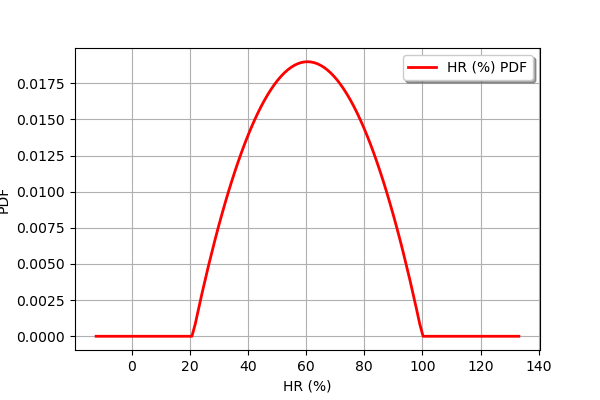

In [43]:
HRBeta_ML14.drawPDF()

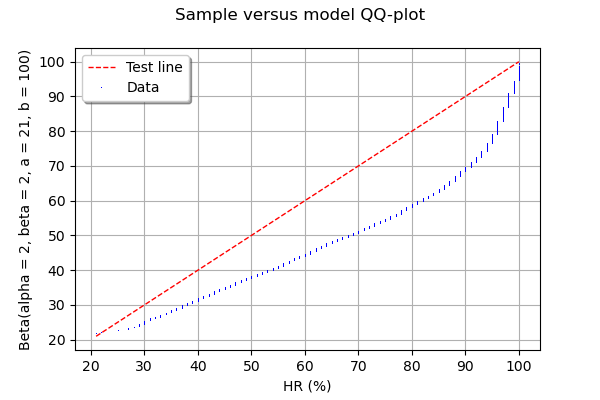

In [44]:
ot.VisualTest_DrawQQplot(sample_HR, HRBeta_ML14)

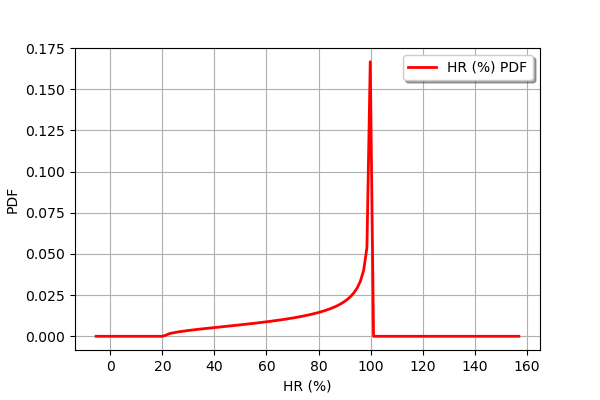

In [45]:
HRBeta_ML15.drawPDF()

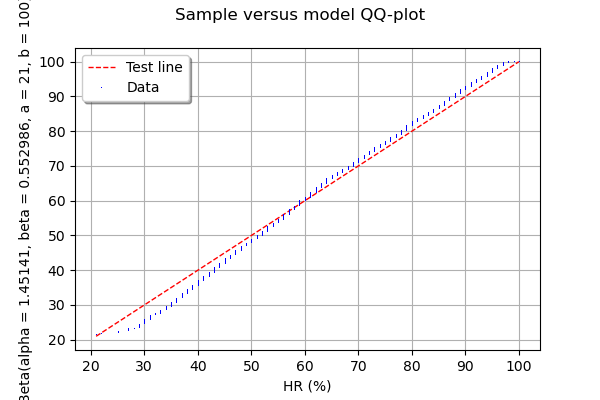

In [46]:
ot.VisualTest_DrawQQplot(sample_HR, HRBeta_ML15)

QQ-Plot

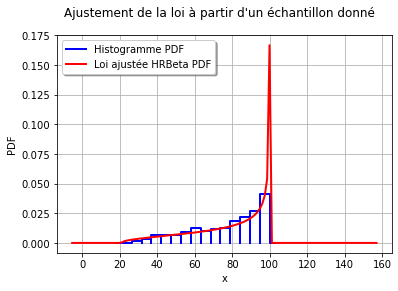

In [47]:
affichagePDF_HR(histo_HR, HRBeta_ML15)

Comme précédemment, la loi ajustée semble suivre la tendance explicitée par l'histogramme. Néanmoins on peut tout de même s'interroger sur la pertinence de la loi ajustée puisque que son maximum, qui est atteint autour de 100 ($\%$ de HR), est bien supérieur au maximum de la distribution estimée par histogramme.

## 8 Dessin de la log-vraissemblance

In [48]:
def log_likelihood(theta):
    alpha, beta= theta
    epsilon = 1e-15
    n = sample_HR.getSize()
    a_chap = sample_HR.getMin() * (1-epsilon)
    b_chap = sample_HR.getMax() * (1+epsilon)
    return [(alpha-1)*np.sum(np.log(sample_HR-a_chap)) + (beta-1)*np.sum(np.log((-1)*sample_HR+b_chap))- n*(alpha+beta-1)*np.log(b_chap-a_chap)[0] - n*np.log(ot.SpecFunc_Beta(alpha,beta))]
    
log_likelihood_Py = ot.PythonFunction(2, 1, log_likelihood)
#log_likelihood_Py = ot.MemoizeFunction(log_likelihood_Py)

In [49]:
X = [2.0, 2.0]
Y = log_likelihood_Py(X)
print(Y)

[-14346.1]


In [50]:
HRBeta_ML15.getParameter()[0]

1.4514076991512714

In [51]:
log_likelihood_Py([HRBeta_ML15.getParameter()[0], HRBeta_ML15.getParameter()[1]])

class=Point name=Unnamed dimension=1 values=[-10996.4]

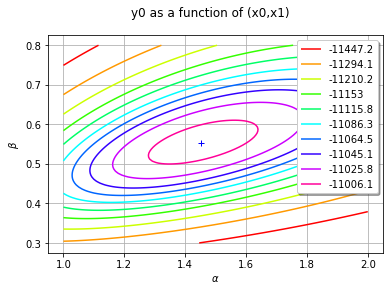

In [52]:
graph_likelihood = log_likelihood_Py.draw([1.0, 0.3], [2.0, 0.8], [100]*2)
graph_likelihood.setXTitle(r"$\alpha$")
graph_likelihood.setYTitle(r"$\beta$")
cloud = ot.Cloud(ot.Sample(1,[HRBeta_ML15.getParameter()[0], HRBeta_ML15.getParameter()[1]]))
graph_likelihood.add(cloud)
view = viewer.View(graph_likelihood)

Observations :

Les iso-valeurs correspondent bien aux résultats escomptés. C'est-à-dire que le point maximal se trouve bien à l'intérieur, et plutôt au centre, de la ligne d'iso-valeur la plus forte. 

## 9. Estimation de la distribution des paramètres

In [53]:
# Estimation theta_chap
FactML = ot.MaximumLikelihoodFactory(ot.Beta())
bestFittML = FactML.buildEstimator(sample_HR)
bestFittML 

class=DistributionFactoryResult distribution=class=Beta name=Beta dimension=1 alpha=2 beta=2 a=-1 b=1 parameterDistribution=class=Dirac name=Dirac dimension=4 point=class=Point name=Unnamed dimension=4 values=[2,2,-1,1]

In [54]:
def Beta_MaxLikelihoodEstimParam(Sample, epsilon):
    """
        Estimation des paramètres d'une loi Beta, à partir d'un échantillon, par maximum de vraisemblance.

    Parameters : 
        - Sample : L'échantillon dont on dispose.

    Returns : 
        - Beta : Distribution Beta estimée par maximum de vraisemblance.
    """
    
    # Minimum et maximum
    a = Sample.getMin()[0]* (1-epsilon)
    b = Sample.getMax()[0]* (1+epsilon)

    # Alpha et beta
    factory = ot.MaximumLikelihoodFactory(ot.Beta())
    factory.setKnownParameter([a, b], [2, 3])
    bounds_lower = [ot.SpecFunc.MinScalar] * 2
    bounds_upper = [1.0] * 2  # Disable anyway (ignored)
    interval = ot.Interval(bounds_lower, bounds_upper, [True] * 2, [False] * 2)
    factory.setOptimizationBounds(interval) 

    dist_theta = factory.buildEstimator(Sample)

    return dist_theta

In [63]:
# Distribution des paramètres
bestFittMLE = Beta_MaxLikelihoodEstimParam(sample_HR, 1e-14)
dist_theta = bestFittMLE.getParameterDistribution()


In [64]:
alpha_beta_dist = dist_theta.getMarginal([0,1])

/Users/martinduguey/opt/anaconda3/lib/python3.9/site-packages/openturns/viewer.py:440: UserWarning: No contour levels were found within the data range.
  contourset = self._ax[0].contour(X, Y, Z, **contour_kw)


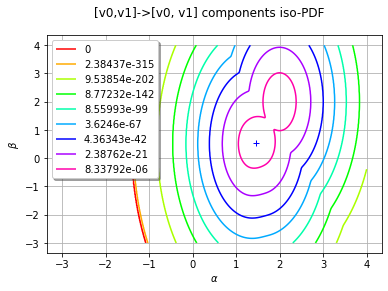

In [65]:
# Iso-valeurs de la distribution de alpha_theta_dist
graph_likelihood2 = alpha_beta_dist.drawMarginal2DPDF(0, 1, [-3.0] * 2, [4.0] * 2, [700] * 2)
graph_likelihood2.setXTitle(r"$\alpha$")
graph_likelihood2.setYTitle(r"$\beta$")
cloud = ot.Cloud(ot.Sample(1,[HRBeta_ML15.getParameter()[0], HRBeta_ML15.getParameter()[1]]))
graph_likelihood2.add(cloud)
graph_likelihood2.setLegendPosition('topleft')
view = viewer.View(graph_likelihood2)

Observations : 

Les iso-valeurs semblent diverger en deux zones. Si on traçait une nouvelle iso-valeur, on verrait apparaître deux ellipses distinctes. On peut donc dire qu'il existe deux couples $(\hat{\alpha}, \hat{\beta})$ qui maximisent la log-vraisemblance.

In [66]:
ot.ResourceMap.SetAsUnsignedInteger(
    "Distribution-MinimumVolumeLevelSetSamplingSize", 1000)

In [67]:
# Intervalle de confiance à 95 %
alpha = 0.95
lvlset, thresh = alpha_beta_dist.computeMinimumVolumeLevelSetWithThreshold(alpha)
lvlset

class=LevelSet name=Unnamed dimension=2 function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[v0,v1,-logPDF] evaluationImplementation=MinimumVolumeLevelSetEvaluation(BlockIndependentDistribution(KernelMixture(kernel = Normal(mu = 0, sigma = 1), bandwidth = [0.0717277,0.192974], sample = 
 0 : [ 2        2        ]
 1 : [ 2        2        ]
 2 : [ 2        2        ]
 3 : [ 2        2        ]
 4 : [ 2        2        ]
 5 : [ 2        2        ]
 6 : [ 2        2        ]
 7 : [ 2        2        ]
 8 : [ 2        2        ]
 9 : [ 2        2        ]
10 : [ 2        2        ]
11 : [ 2        2        ]
12 : [ 2        2        ]
13 : [ 2        2        ]
14 : [ 1.4811   0.572567 ]
15 : [ 2        2        ]
16 : [ 2        2        ]
17 : [ 2        2        ]
18 : [ 2        2        ]
19 : [ 2        2        ]
20 : [ 2        2        ]
21 : [ 2        2        ]
22 : [ 2        2        ]
23 : [ 2        2        ]
24 : [ 2        2        ]
25 : [ 2        2        ]
26 : [ 2        2        ]
27 : [ 2        2        ]
28 : [ 2        2        ]
29 : [ 2        2        ]
30 : [ 2        2        ]
31 : [ 2        2        ]
32 : [ 2        2        ]
33 : [ 2        2        ]
34 : [ 2        2        ]
35 : [ 2        2        ]
36 : [ 2        2        ]
37 : [ 2        2        ]
38 : [ 2        2        ]
39 : [ 2        2        ]
40 : [ 1.58597  0.596158 ]
41 : [ 2        2        ]
42 : [ 2        2        ]
43 : [ 2        2        ]
44 : [ 2        2        ]
45 : [ 2        2        ]
46 : [ 2        2        ]
47 : [ 2        2        ]
48 : [ 2        2        ]
49 : [ 2        2        ]
50 : [ 2        2        ]
51 : [ 2        2        ]
52 : [ 2        2        ]
53 : [ 2        2        ]
54 : [ 2        2        ]
55 : [ 2        2        ]
56 : [ 2        2        ]
57 : [ 2        2        ]
58 : [ 2        2        ]
59 : [ 2        2        ]
60 : [ 2        2        ]
61 : [ 2        2        ]
62 : [ 2        2        ]
63 : [ 2        2        ]
64 : [ 2        2        ]
65 : [ 2        2        ]
66 : [ 2        2        ]
67 : [ 2        2        ]
68 : [ 1.43236  0.560462 ]
69 : [ 2        2        ]
70 : [ 2        2        ]
71 : [ 1.36612  0.513483 ]
72 : [ 2        2        ]
73 : [ 2        2        ]
74 : [ 2        2        ]
75 : [ 2        2        ]
76 : [ 2        2        ]
77 : [ 2        2        ]
78 : [ 2        2        ]
79 : [ 2        2        ]
80 : [ 2        2        ]
81 : [ 2        2        ]
82 : [ 2        2        ]
83 : [ 2        2        ]
84 : [ 2        2        ]
85 : [ 2        2        ]
86 : [ 2        2        ]
87 : [ 2        2        ]
88 : [ 2        2        ]
89 : [ 2        2        ]
90 : [ 2        2        ]
91 : [ 2        2        ]
92 : [ 2        2        ]
93 : [ 1.44947  0.549212 ]
94 : [ 2        2        ]
95 : [ 2        2        ]
96 : [ 1.50608  0.583326 ]
97 : [ 2        2        ]
98 : [ 2        2        ]
99 : [ 2        2        ])) gradientImplementation=MinimumVolumeLevelSetGradient(BlockIndependentDistribution(KernelMixture(kernel = Normal(mu = 0, sigma = 1), bandwidth = [0.0717277,0.192974], sample = 
 0 : [ 2        2        ]
 1 : [ 2        2        ]
 2 : [ 2        2        ]
 3 : [ 2        2        ]
 4 : [ 2        2        ]
 5 : [ 2        2        ]
 6 : [ 2        2        ]
 7 : [ 2        2        ]
 8 : [ 2        2        ]
 9 : [ 2        2        ]
10 : [ 2        2        ]
11 : [ 2        2        ]
12 : [ 2        2        ]
13 : [ 2        2        ]
14 : [ 1.4811   0.572567 ]
15 : [ 2        2        ]
16 : [ 2        2        ]
17 : [ 2        2        ]
18 : [ 2        2        ]
19 : [ 2        2        ]
20 : [ 2        2        ]
21 : [ 2        2        ]
22 : [ 2        2        ]
23 : [ 2        2        ]
24 : [ 2        2        ]
25 : [ 2        2        ]
26 : [ 2        2        ]
27 : [ 2        2        ]
28 : [ 2        2       

La fonction ci dessous a été trouvé sur une page d'exemple de Openturns :
https://openturns.github.io/openturns/latest/auto_probabilistic_modeling/distributions/plot_minimum_volume_level_sets.html?highlight=computeminimumvolumelevelsetwiththreshold

In [68]:
def drawLevelSetContour2D(distribution, numberOfPointsInXAxis, alpha, threshold, sampleSize=500):
    '''
    Compute the minimum volume LevelSet of measure equal to alpha and get the
    corresponding density value (named threshold).
    Generate a sample of the distribution and draw it.
    Draw a contour plot for the distribution, where the PDF is equal to threshold.
    '''
    sample = distribution.getSample(sampleSize)
    X1min = sample[:, 0].getMin()[0]
    X1max = sample[:, 0].getMax()[0]
    X2min = sample[:, 1].getMin()[0]
    X2max = sample[:, 1].getMax()[0]
    xx = ot.Box([numberOfPointsInXAxis],
                ot.Interval([X1min], [X1max])).generate()
    yy = ot.Box([numberOfPointsInXAxis],
                ot.Interval([X2min], [X2max])).generate()
    xy = ot.Box([numberOfPointsInXAxis, numberOfPointsInXAxis],
                ot.Interval([X1min, X2min], [X1max, X2max])).generate()
    data = distribution.computePDF(xy)
    graph = ot.Graph('', 'X1', 'X2', True, 'topright')
    labels = ["%.2f%%" % (100*alpha)]
    contour = ot.Contour(xx, yy, data, [threshold], labels)
    contour.setColor('black')
    graph.setTitle("%.2f%% of the distribution, sample size = %d" %
                   (100*alpha, sampleSize))
    graph.add(contour)
    cloud = ot.Cloud(sample)
    graph.add(cloud)
    return graph

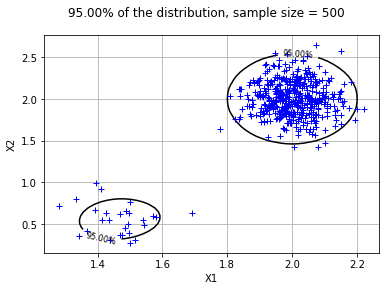

In [69]:
numberOfPointsInXAxis = 50
graph = drawLevelSetContour2D(alpha_beta_dist, numberOfPointsInXAxis, alpha, thresh)
view = viewer.View(graph)
plt.show()

Observations :

On peut clairement voir qu'il y a deux zones dans lesquelles on peut chercher un point de maximum. La forme du graphique des iso-valeurs de la fonction de probabilité de la loi du couple des estimateurs $(\hat{\alpha}, \hat{\beta})$, s'explique par le fait que la fonction de densité admet deux maximas locaux. La figure, ci-dessus permet de s'en convaincre.

## 10 Synthèse

| Paramètre | $\alpha$ | $\beta$ | $a$ | $b$ | 
|------------- |-------------|-------------|-------------|-------------|
|méthode des moments (BetaFacotry)| 1.88684 | 0.765074 | 20.9716 | 100.028 |
|modèle BIC|1.88684| 0.765074 | 20.9716 | 100.028 |
|maximum de vraisemblance 1 | 1.45141 | 0.552986 | 21 | 100 |
|maximum de vraisemblance 2 | 2.0 | 2.0 | 21 | 100 |

À titre informatif nous avons fait apparaître les estimations des paramètres utilisés pour calculer la meilleure distribution au sens du critère BIC, même si la méthode appelle la classe $\textit{BetaFactory}$. Les paramètres sont donc identiques. On fait aussi apparaître les deux maximas globaux obtenus par maximastion de la log-vraisemblance.

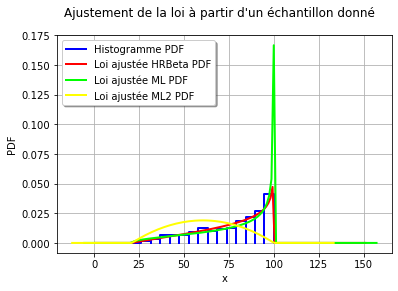

In [72]:
HRBeta_MLE = bestFittMLE.getDistribution()
affichagePDF_HR(histo_HR, HRBeta, None, HRBeta_ML15, HRBeta_MLE)

Malgré le fait que l'on ait réussi à construire plusieurs loi à densité qui s'ajustent visuellement à la distribution, soit la statistique de Kolmogorov-Smirnov contredit l'ajustement (loi Beta par méthode des moments, loi par lissage à noyau), soit l'ajustement est multiple et n'est pas forcément cohérent (loi Beta par maximisation de la vraisemblance). 


- Une des solutions pour palier à ce problème serait de fournir un peu plus notre échantillon de départ de manière à influer directement sur la statistique de Kolmogorov-Smirnov. On peut le faire soit par de nouveaux relevés de l'humidité relative, soit par méthode de bootstrap.

- Une autre solution serait d'estimer différement les parmètres de la loi Beta, en utilisant une méthode des moments généralisée par exemple.